# MiniProject 3

## LIBRARIES

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, BaggingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import adjusted_rand_score, r2_score, mean_squared_error, confusion_matrix, classification_report, silhouette_score, accuracy_score, roc_auc_score, roc_curve, auc

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## OVERVIEW

The purpose of my project will be to classify 4 types of vehicles using unsupervised machine learning models based on 17 variables of the cars silhouette
The 17 variables that I will use to differentiate between the 4 cars are explained below 

COMPACTNESS     (average perim)2/area
     
     CIRCULARITY     (average radius)2/area
     
     DISTANCE CIRCULARITY    area/(av.distance from border)2
     
     RADIUS RATIO    (max.rad-min.rad)/av.radius
     
     PR.AXIS ASPECT RATIO    (minor axis)/(major axis)
     
     MAX.LENGTH ASPECT RATIO (length perp. max length)/(max length)
     
     SCATTER RATIO   (inertia about minor axis)/(inertia about major axis)
     
     ELONGATEDNESS           area/(shrink width)2
     
     PR.AXIS RECTANGULARITY  area/(pr.axis length*pr.axis width)
     
     MAX.LENGTH RECTANGULARITY area/(max.length*length perp. to this)
     
     SCALED VARIANCE         (2nd order moment about minor axis)/area
     ALONG MAJOR AXIS
     
     SCALED VARIANCE         (2nd order moment about major axis)/area
     ALONG MINOR AXIS 
     
     SCALED RADIUS OF GYRATION       (mavar+mivar)/area
     
     SKEWNESS ABOUT  (3rd order moment about major axis)/sigma_min3
     MAJOR AXIS
     
     SKEWNESS ABOUT  (3rd order moment about minor axis)/sigma_maj3
     MINOR AXIS
             
     KURTOSIS ABOUT  (4th order moment about major axis)/sigma_min4
     MINOR AXIS  
             
     KURTOSIS ABOUT  (4th order moment about minor axis)/sigma_maj4
     MAJOR AXIS
     
     HOLLOWS RATIO   (area of hollows)/(area of bounding polygon)
     
      Where sigma_maj2 is the variance along the major axis and
     sigma_min2 is the variance along the minor axis, and
     
     area of hollows= area of bounding poly-area of object 
     
      The area of the bounding polygon is found as a side result of
     the computation to find the maximum length. Each individual
     length computation yields a pair of calipers to the object
     orientated at every 5 degrees. The object is propagated into
     an image containing the union of these calipers to obtain an
     image of the bounding polygon. 

The 4 cars that are in the dataset in which we are trying to sort into can be seen below:

In [143]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Opel_Manta_i400_Replica_%281985%29.jpg/1200px-Opel_Manta_i400_Replica_%281985%29.jpg", width=500, height=500)

In [144]:
Image(url="https://i0.wp.com/saabblog.net/wp-content/uploads/2020/11/Saab_9000_Aero_1993_1.jpeg?ssl=1", width=500, height=500)

In [145]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/8/89/2021_Chevrolet_Express_2500_WT_Cargo_in_Summit_White%2C_Front_Left%2C_05-22-2022.jpg", width=500, height=500) 

In [146]:
Image(url="https://media.tacdn.com/media/attractions-splice-spp-674x446/07/b0/b8/e0.jpg", width=500, height=500) 

From these images I expect the model to be able to easily differentiate between the double decker bus and van agianst the SAAB and Opel. Because the SAAB and Opel have similar silhouettes, and because our models are only purely based on data on the silhouette it will be much harder to find two clusters between them

# TASK A

## EXPLORATORY DATA ANALYSIS

In [147]:
cars = pd.read_csv(r'C:\Users\user\Documents\Data Science\Data sets\vehicle_csv.csv')

In [148]:
#this is our y
y = cars['Class']

In [149]:
#this is our X
x = cars.drop(columns = 'Class')

In [150]:
y.value_counts()

bus     218
saab    217
opel    212
van     199
Name: Class, dtype: int64

Roughly the same number of each car type

In [151]:
x.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183


In [152]:
print('There are', len(x), 'datapoints, with', len(x.columns), 'dimensions')

There are 846 datapoints, with 18 dimensions


In [153]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,93.678487,8.234474,73.0,87.00,93.0,100.0,119.0
CIRCULARITY,846.0,44.861702,6.169866,33.0,40.00,44.0,49.0,59.0
DISTANCE_CIRCULARITY,846.0,82.088652,15.771533,40.0,70.00,80.0,98.0,112.0
RADIUS_RATIO,846.0,168.940898,33.472183,104.0,141.00,167.0,195.0,333.0
PR.AXIS_ASPECT_RATIO,846.0,61.693853,7.888251,47.0,57.00,61.0,65.0,138.0
MAX.LENGTH_ASPECT_RATIO,846.0,8.567376,4.601217,2.0,7.00,8.0,10.0,55.0
SCATTER_RATIO,846.0,168.839243,33.244978,112.0,146.25,157.0,198.0,265.0
ELONGATEDNESS,846.0,40.933806,7.811560,26.0,33.00,43.0,46.0,61.0
PR.AXIS_RECTANGULARITY,846.0,20.582742,2.592138,17.0,19.00,20.0,23.0,29.0
MAX.LENGTH_RECTANGULARITY,846.0,147.998818,14.515652,118.0,137.00,146.0,159.0,188.0


compactness, circularity, distance_circularity, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about.2, hollows_ratio are approximately normally distributed.

radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, scaled_variance, scaled_variance.1, skewness_about, skewness_about.1 are approx. right skewed distribution.

In [154]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   COMPACTNESS                846 non-null    int64
 1   CIRCULARITY                846 non-null    int64
 2   DISTANCE_CIRCULARITY       846 non-null    int64
 3   RADIUS_RATIO               846 non-null    int64
 4   PR.AXIS_ASPECT_RATIO       846 non-null    int64
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    int64
 6   SCATTER_RATIO              846 non-null    int64
 7   ELONGATEDNESS              846 non-null    int64
 8   PR.AXIS_RECTANGULARITY     846 non-null    int64
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    int64
 10  SCALED_VARIANCE_MAJOR      846 non-null    int64
 11  SCALED_VARIANCE_MINOR      846 non-null    int64
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    int64
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    int64
 14  SKEWNESS_ABOUT_MINOR      

All 18 variables have 846 non-null numeric data points.

In [155]:
#store variable names
name = x.columns
name

Index(['COMPACTNESS', 'CIRCULARITY', 'DISTANCE_CIRCULARITY', 'RADIUS_RATIO',
       'PR.AXIS_ASPECT_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SCATTER_RATIO',
       'ELONGATEDNESS', 'PR.AXIS_RECTANGULARITY', 'MAX.LENGTH_RECTANGULARITY',
       'SCALED_VARIANCE_MAJOR', 'SCALED_VARIANCE_MINOR',
       'SCALED_RADIUS_OF_GYRATION', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'KURTOSIS_ABOUT_MAJOR', 'KURTOSIS_ABOUT_MINOR',
       'HOLLOWS_RATIO'],
      dtype='object')

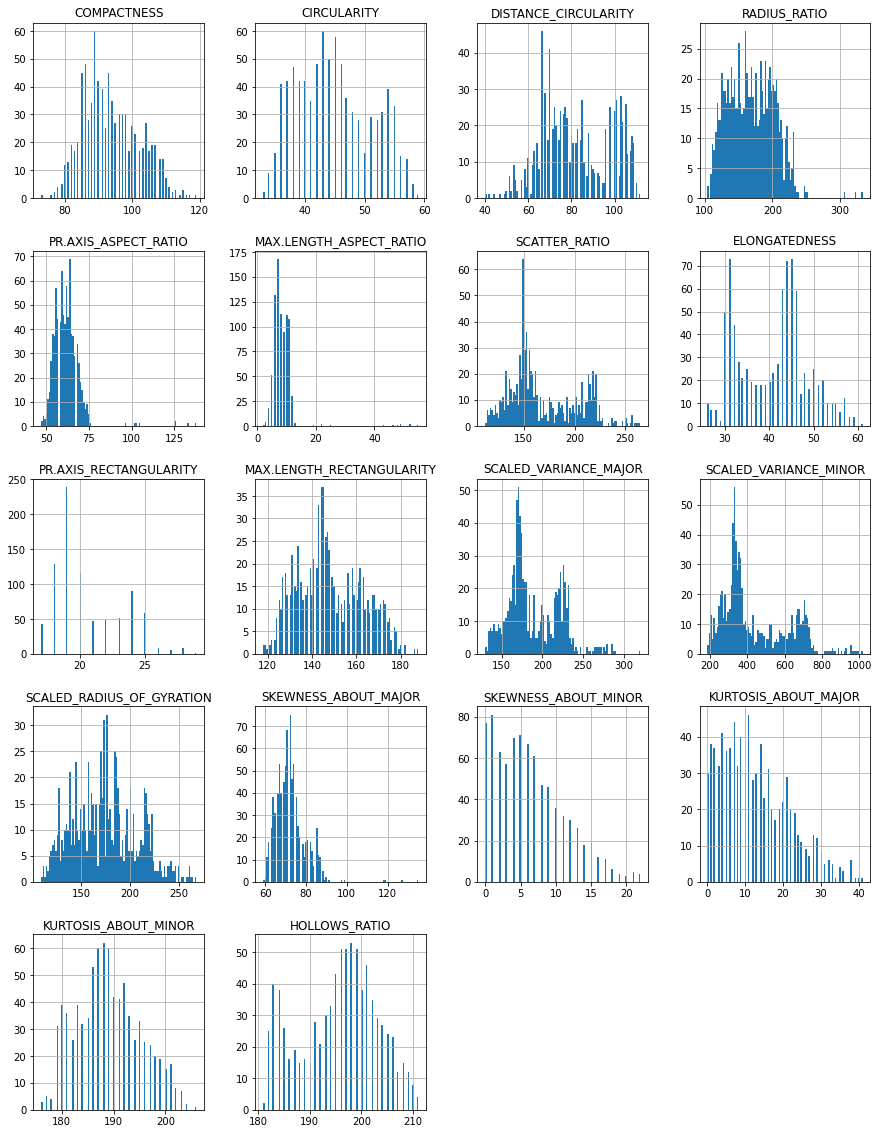

In [156]:
x.hist(bins = 100, figsize = (15, 20))
plt.show()

Most graphs have more than one modes, meaning that there are multiple peaks in the graph. This is a great sign for us having to differentiate our given values into groups based on there position on the graph. These peaks are the precursor to our clustering.

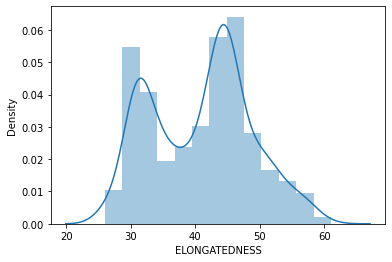

In [157]:
sns_plot = sns.distplot(x['ELONGATEDNESS'])

You can see the two peaks, I would assume the one on the left is the SAAB and Opel and the spike on the right is the van and bus.

<AxesSubplot:>

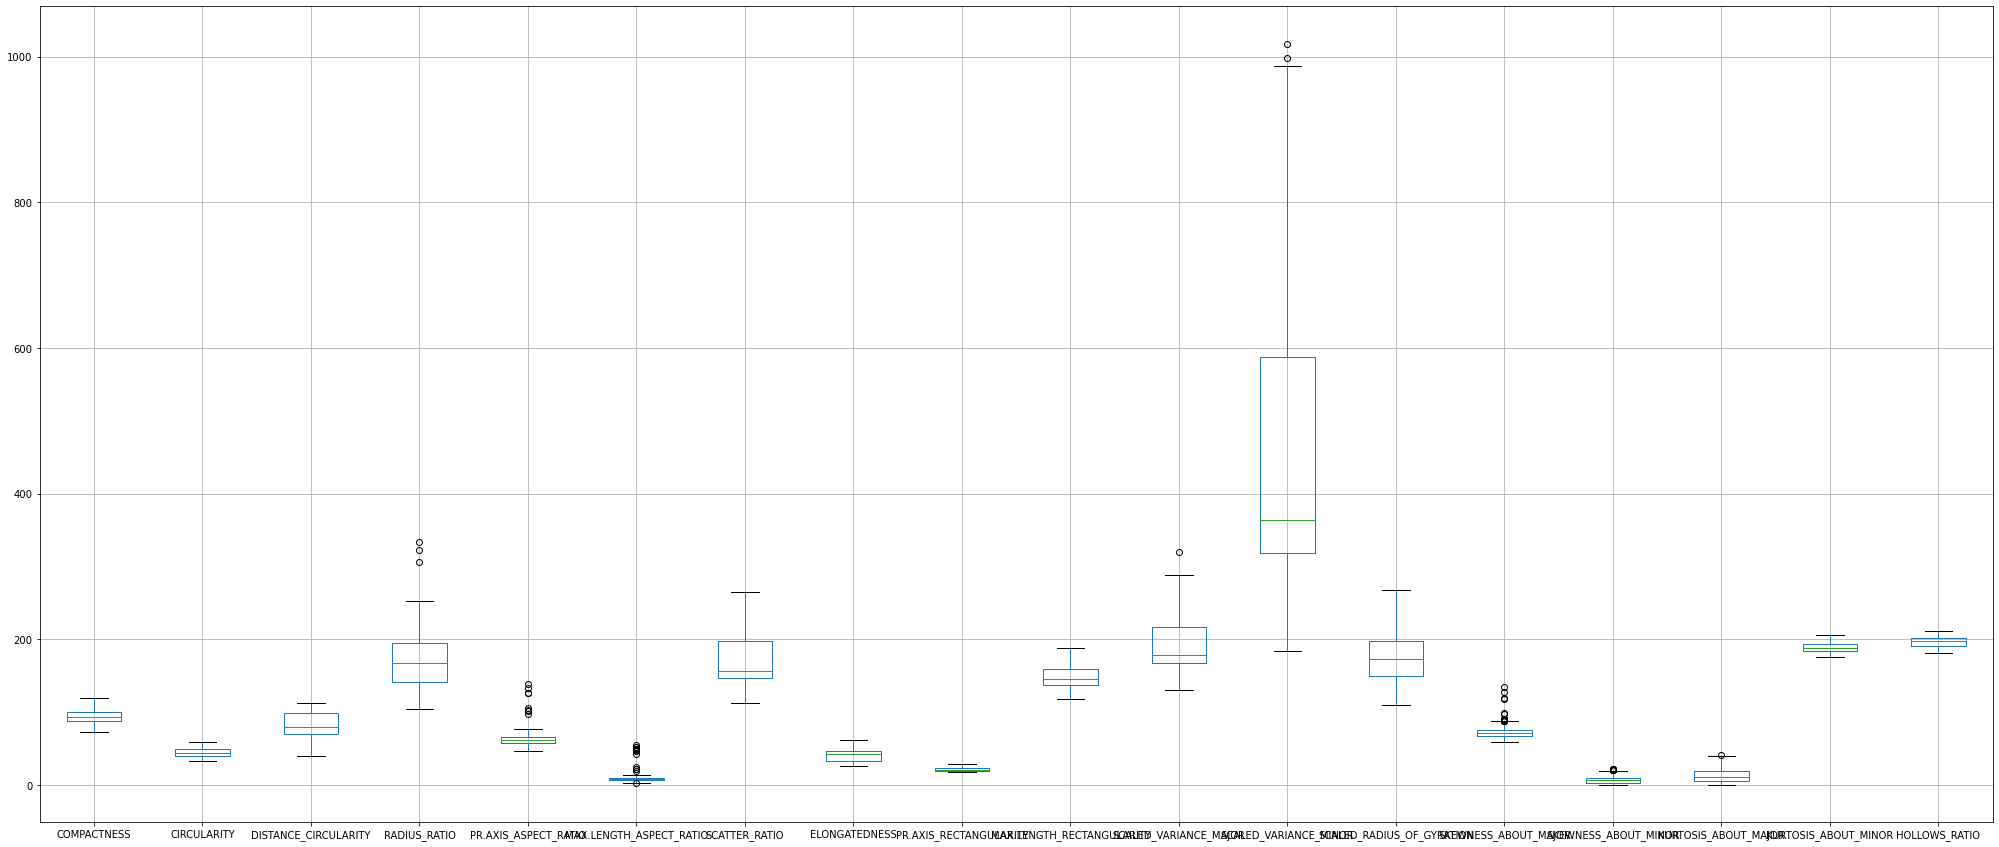

In [158]:
# Understand the spread and outliers in dataset using boxplot
x.boxplot(figsize=(35,15))

It is showing that there are some columns which contains outliers such as radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance, scaled_variance, skewness_about, skewness. It also shows the magnitudes of each variable.

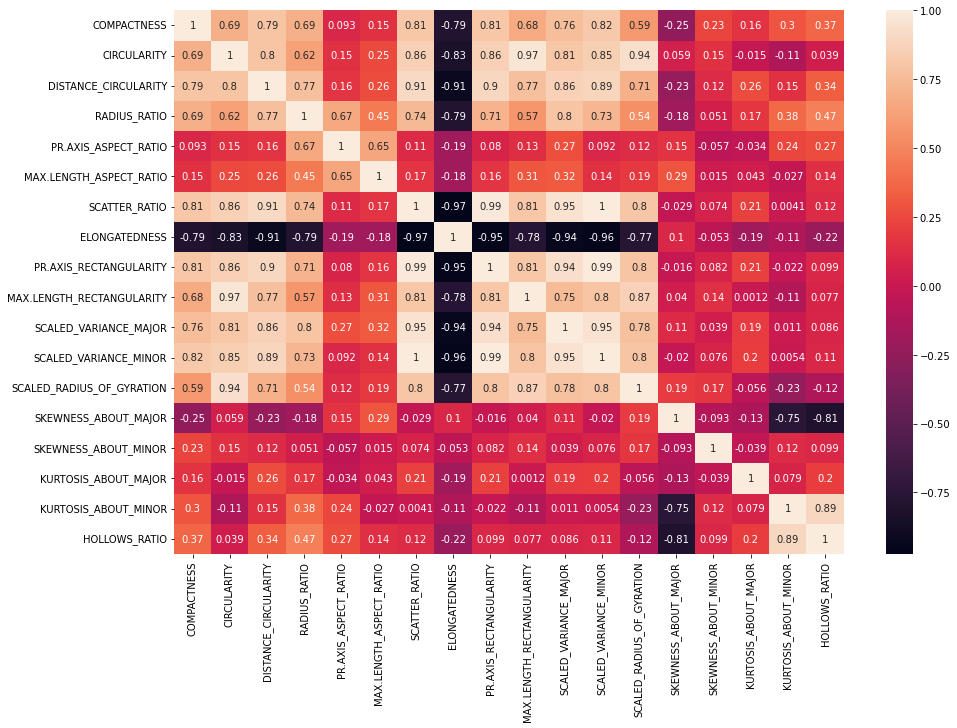

In [159]:
plt.figure(figsize = (15,10))
corr = x.corr()
sns.heatmap(corr, annot = True)
plt.show()

It shows that there are some attributes which are highly correlated as there corelation value is very high.

For example: compactness is highly correlated in a positive way with scatter_ratio, pr.axis_rectangularity, scaled_variance1, distance_circularity, scaled_variance, radius_ratio. compactness is highly correlated in a negative way with elongatedness.

## Cleaning Data

In [160]:
x.isna().sum()

COMPACTNESS                  0
CIRCULARITY                  0
DISTANCE_CIRCULARITY         0
RADIUS_RATIO                 0
PR.AXIS_ASPECT_RATIO         0
MAX.LENGTH_ASPECT_RATIO      0
SCATTER_RATIO                0
ELONGATEDNESS                0
PR.AXIS_RECTANGULARITY       0
MAX.LENGTH_RECTANGULARITY    0
SCALED_VARIANCE_MAJOR        0
SCALED_VARIANCE_MINOR        0
SCALED_RADIUS_OF_GYRATION    0
SKEWNESS_ABOUT_MAJOR         0
SKEWNESS_ABOUT_MINOR         0
KURTOSIS_ABOUT_MAJOR         0
KURTOSIS_ABOUT_MINOR         0
HOLLOWS_RATIO                0
dtype: int64

Great! no null values

In [161]:
#check for 0 values with physically impossible 0.
indexs = []
var_zero = []
for index, names in enumerate(name):
  for i in range(len(x)):
        if x[names].iloc[i] == 0:
            #saving index of the 0 value
            indexs.append(i)
            #saving variable thats 0
            var_zero.append(index)
zeros = np.unique(indexs)

In [162]:
#sees which dimensions have the 0 values
np.unique(var_zero)

array([14, 15])

In [163]:
for index, names in enumerate(name):
    print(index, names)

0 COMPACTNESS
1 CIRCULARITY
2 DISTANCE_CIRCULARITY
3 RADIUS_RATIO
4 PR.AXIS_ASPECT_RATIO
5 MAX.LENGTH_ASPECT_RATIO
6 SCATTER_RATIO
7 ELONGATEDNESS
8 PR.AXIS_RECTANGULARITY
9 MAX.LENGTH_RECTANGULARITY
10 SCALED_VARIANCE_MAJOR
11 SCALED_VARIANCE_MINOR
12 SCALED_RADIUS_OF_GYRATION
13 SKEWNESS_ABOUT_MAJOR
14 SKEWNESS_ABOUT_MINOR
15 KURTOSIS_ABOUT_MAJOR
16 KURTOSIS_ABOUT_MINOR
17 HOLLOWS_RATIO


Only the 14th and 15th variables have 0 values where 14 is the Skewness about minor and 15 is kurtosis about major. Skewness can physically be 0, meaning that the 3rd order moment about minor axis is symettrical. The kurtosis being 0 means that the 4th order moment about major axis graphed would look platykurtic, a small bump, compared to a large spike if kurtosis was high.

These variables being 0 makes real world sense and doesnt need to be cleaned.

In [164]:
#Function to normalise data
def normalise_data(df):
    df_new = pd.DataFrame()
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        df_new[col] = (df[col] - mean) / std
    return df_new

In [165]:
X = normalise_data(x)

In [166]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,5.572112e-16,1.000592,-2.512695,-0.811520,-0.082445,0.768143,3.076880
CIRCULARITY,846.0,-3.217810e-16,1.000592,-1.923659,-0.788441,-0.139746,0.671124,2.292864
DISTANCE_CIRCULARITY,846.0,-3.398910e-16,1.000592,-2.670226,-0.766939,-0.132510,1.009462,1.897662
RADIUS_RATIO,846.0,-1.813627e-16,1.000592,-1.941293,-0.835244,-0.058020,0.778991,4.904256
PR.AXIS_ASPECT_RATIO,846.0,-6.167906e-18,1.000592,-1.863854,-0.595396,-0.088012,0.419371,9.679114
MAX.LENGTH_ASPECT_RATIO,846.0,-1.732263e-16,1.000592,-1.428157,-0.340845,-0.123383,0.311542,10.097349
SCATTER_RATIO,846.0,-3.669248e-16,1.000592,-1.710721,-0.679880,-0.356332,0.877667,2.894201
ELONGATEDNESS,846.0,2.165329e-16,1.000592,-1.912888,-1.016250,0.264661,0.648935,2.570302
PR.AXIS_RECTANGULARITY,846.0,-7.165269e-17,1.000592,-1.382975,-0.610954,-0.224944,0.933086,3.249146
MAX.LENGTH_RECTANGULARITY,846.0,8.091767e-16,1.000592,-2.067876,-0.758169,-0.137782,0.758332,2.757358


### Local Outlier Factor

I will be using local outlier factor as my unsupervised anomaly detection method. The local outlier factor works by computing the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

The main optimization we can apply to the LocalOutlierFactor function is n_neighbors and contamination

To calculate a good number for n neighbors we can find the amount that each cluster should have.

The total number of values(846) / Number of clusters(4)

giving us n = 211

Contamination is the amount of the dataset that you think is an outlier.

Sklearns automatically asigns this value to be 0.1 so 10% of the data. I feel that number is a bit to high and will be using 1% so 0.01

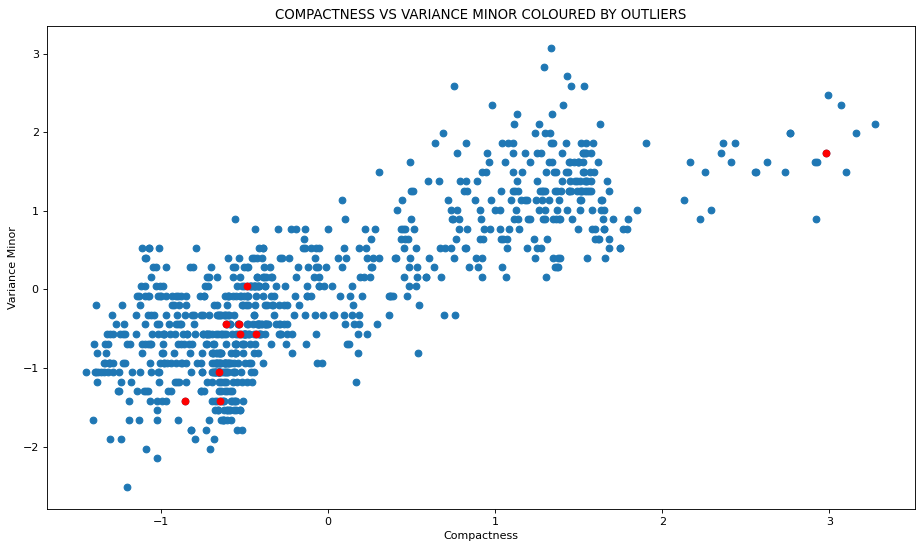

In [167]:
#initializing the function
clf = LocalOutlierFactor(n_neighbors=211, contamination=0.01)
#fitting the data
y_pred = clf.fit_predict(X)
#all negative values are considered to be outliers
lofs_index = np.where(y_pred==-1)
#storing all outliers
values = X.iloc[lofs_index]

#plotting the outliers
plt.figure(figsize=(14, 8), dpi=80)
plt.scatter(y = X['COMPACTNESS'], x = X['SCALED_VARIANCE_MINOR'])
plt.scatter(y = values['COMPACTNESS'], x =values['SCALED_VARIANCE_MINOR'], c = 'r')
plt.title("COMPACTNESS VS VARIANCE MINOR COLOURED BY OUTLIERS")
plt.xlabel("Compactness")
plt.ylabel("Variance Minor")
plt.show()

In [168]:
#taking the outliers out, axis = 0 refers to the rows being taken out
for values, index in enumerate(lofs_index):
    print(index)
clean = X.drop(index, axis = 0)
clean

[  4  37 100 135 291 388 396 523 706]


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
0,0.160580,0.508950,0.057819,0.270806,1.307291,0.311542,-0.205844,0.136570,-0.224944,0.758332,-0.402383,-0.344935,0.285812,-0.329056,-0.076711,0.380991,-0.313722,0.183957
1,-0.325470,-0.626268,0.121261,-0.835244,-0.595396,0.094079,-0.597112,0.520843,-0.610954,-0.344578,-0.593611,-0.622416,-0.513517,-0.061767,0.533610,0.156925,0.010937,0.452977
2,1.254193,0.833298,1.517005,1.197496,0.546217,0.311542,1.148544,-1.144341,0.933086,0.689401,1.095564,1.104766,1.392577,0.071877,1.550812,-0.403238,-0.151393,0.049447
3,-0.082445,-0.626268,-0.005624,-0.297166,0.165679,0.094079,-0.747600,0.648935,-0.610954,-0.344578,-0.912323,-0.741337,-1.466565,-1.264566,-0.076711,-0.291206,1.634233,1.529056
5,1.618730,1.968516,1.517005,0.091446,-1.483316,-0.558308,2.593225,-1.912888,2.863136,1.447652,2.912223,2.928218,2.745289,1.675609,-0.280151,-0.403238,-1.287700,-1.699181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,-0.082445,-0.950615,0.311590,0.420272,0.292525,-0.123383,0.004838,-0.119612,-0.224944,-0.964965,0.362526,-0.101430,-0.790209,-0.061767,0.126729,1.389286,-0.151393,-0.085062
842,-0.568495,0.184602,0.121261,-0.177593,0.546217,0.529004,-0.296137,0.264661,-0.224944,0.758332,-0.497997,-0.407226,0.039865,-0.061767,-1.093913,0.829122,-0.476052,0.183957
843,1.497218,1.481994,1.199790,1.586108,0.673062,0.746467,1.600007,-1.400524,1.705106,1.723379,1.254920,1.591775,0.777708,-0.329056,-0.687032,-0.963402,-0.313722,0.721997
844,-0.933032,-1.437137,-0.259396,-0.685777,-0.468550,-0.340845,-1.018477,1.161299,-0.996965,-1.654284,-1.071679,-0.962190,-0.820952,-0.863633,-1.297353,1.389286,0.173267,-0.085062


This will be all the cleaning we will do to our data. We have normalized it meaning all our variables all have the same magnitude, which will mean our model will have no bias towards one variable. We then used local outlier factor to seperate the outliers from the real data.

Visually showing the difference in spread before and after changes you can clearly see our methods have worked:

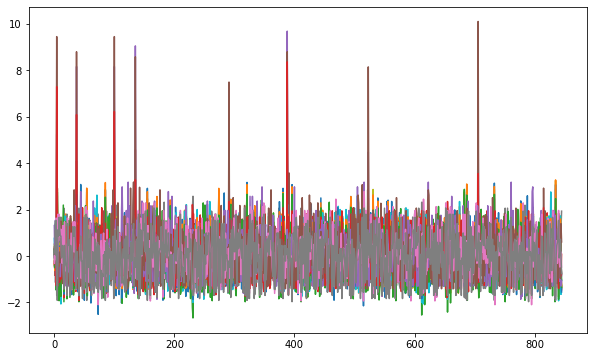

In [169]:
#spread of untreated data
plt.rcParams['figure.figsize']=(10,6)
plt.plot(X)
plt.show()

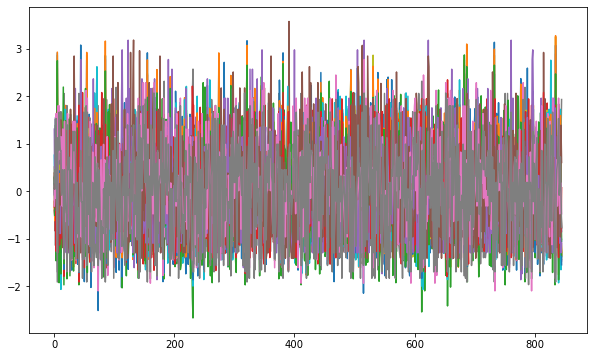

In [170]:
#spread of cleaned data
plt.rcParams['figure.figsize']=(10,6)
plt.plot(clean)
plt.show()

In [171]:
#cleaning y aswell
cleany = y.drop(index, axis = 0)

# UNSUPERVISED MACHINE LEARNING

### DBSCAN

First unsupervised model I will be using is DBSCAN, Density-based clustering determines cluster assignments based on the density of data points in a region. Clusters are assigned where there are high densities of data points separated by low-density regions.

DBSCAN excels at identifying clusters of nonspherical shapes. It is also very resilient to outliers as they dont make much of a difference to the position of the cluster

DBSCANS draw backs are its susceptibility to the curse of dimensionalilty and if the clusters have varrying sizes

We have 17 variables that we are wanting to pass into DBSCAN. We can optimize the model by setting minPts to be two times the number of variables so well set it to 34

The next hyperparameter we can optimize is ε. Epsilon depends on the distance function, to find this value we will use another model called K Nearest Neighbours

In [172]:
#alittle smaller n_neigbors so there are some data points accounted for as noise
nbrs = NearestNeighbors(n_neighbors=200).fit(clean)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(clean)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

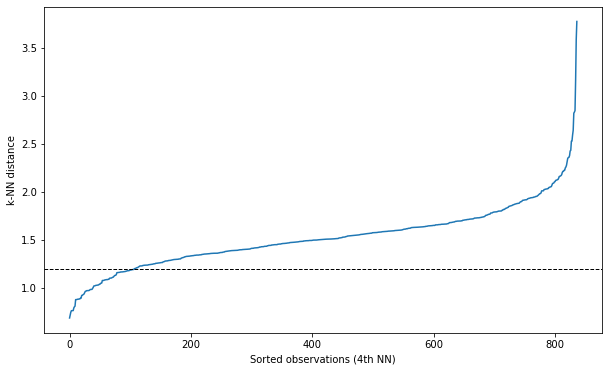

In [173]:
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(1.2, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In the k-NN distance plot, you should look for the “knee” of the curve to find the optimal value of ε. In the below plot, the knee occurs at approximately 2.5 i.e. the points below 2.5 belong to a cluster and points above 2.5 are noise or outliers (noise points will have higher kNN distance).

In [174]:
#hyperparamters found above
clusters = DBSCAN(eps=2.5, min_samples=34).fit(clean)
# get cluster labels
clusters.labels_
set(clusters.labels_)

{-1, 0}

In [175]:
Counter(clusters.labels_)

Counter({0: 806, -1: 31})

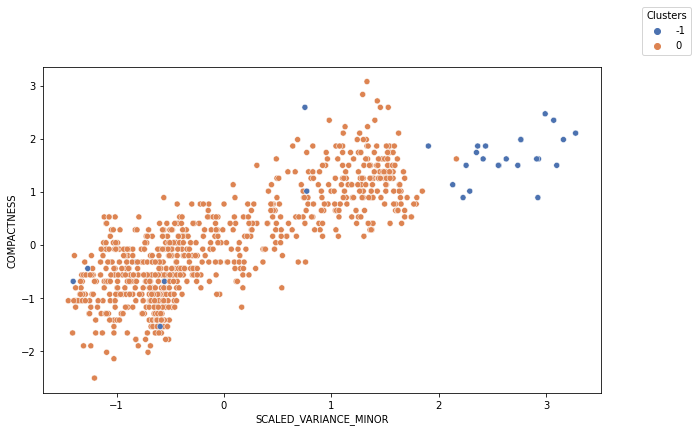

In [176]:
p = sns.scatterplot(data=clean, x="SCALED_VARIANCE_MINOR", y="COMPACTNESS", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

DBSCAN predicts one cluster being 0, and -1 represents the outliers or noise. DBSCAN proved not to be very accurate with our model, most likely due to its curse of dimensionalilty

DBSCAN is computationally expensive (less scalable) and more complicated clustering method as compared to simple k-means clustering
DBSCAN is sensitive to input parameters, and it is hard to set accurate input parameters
DBSCAN depends on a single value of ε for all clusters, and therefore, clusters with variable densities may not be correctly identified by DBSCAN
DBSCAN is a time-consuming algorithm for clustering

https://www.reneshbedre.com/blog/dbscan-python.html

### K MEANS

K-Means clustering is generally used on numerical data to solve classification problems. Its main goal is to group similar elements or data points together into pre-defined, non-overlapping clusters where each data point belongs to only one group.

In unsupervised learning, there is no target variable. The dataset only has input variables which describe the data. This is called unsupervised learning.

Normally when implimenting this model you have an idea of how many subgroups you are looking for.
The “K” in K-Means represent the number of centroid and in this case we will set K = 4 as there are 4 car types.

A centroid is a data point at the centre of a cluster, where this centre is iteratively recalculated using the smallest amount of guassian distance between all clustered points.

If the number of centroids is unknown a technique called the elbow method can be used. This method plots the average distance between points and centroid by the number of centroids. The most optimal value of centroids is the smallest distance with the smallest number of centroids. This can be seen graphically in the most bottom left point in the graph.

I will use this technique later to find if our model is accurately prediciting that this method is comprised of 4 different cars.


It is very important that you normalize and scale your values when using K-means. K-means clustering is "isotropic" in all directions of space and therefore tends to produce more or less round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering

n_clusters sets k for the clustering step. This is the most important parameter for k-means.

n_init sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

max_iter sets the number of maximum iterations for each initialization of the k-means algorithm.

In [177]:
#setting enviroment for K-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans2 = KMeans(n_clusters=4, random_state=42)

#fitting to our data
kmeans.fit(clean)
kmeans2.fit(X)

KMeans(n_clusters=4, random_state=42)

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, minimizing a criterion known as inertia

The lower values of inertia are better and zero is optimal. But in very high-dimensional spaces, euclidean distances tend to become inflated (this is an instance of curse of dimensionality).

In [178]:
sse = kmeans.inertia_
sse2 = kmeans2.inertia_
print(sse, sse2)

5259.324863615816 6671.879042317768


We can see that both models have very high inertia but our uncleaned dataset performed worst than our cleaned meaning that our local outlier factor was successful.

In [179]:
# The number of iterations required to converge
kmeans.n_iter_

11

Text(0, 0.5, 'Variance Minor')

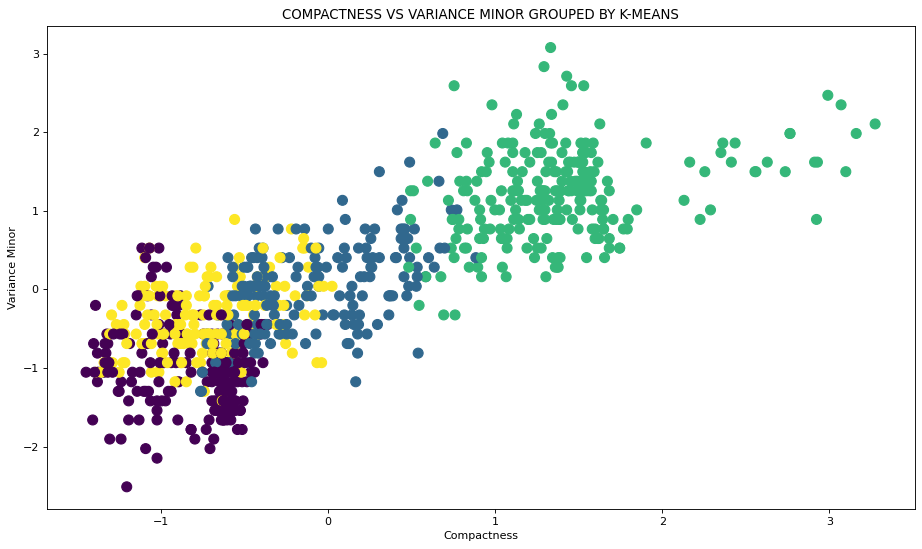

In [180]:
plt.figure(figsize=(14, 8), dpi=80)
plt.scatter(y = clean['COMPACTNESS'], x =clean['SCALED_VARIANCE_MINOR'], c = kmeans.labels_, s = 80)
plt.title("COMPACTNESS VS VARIANCE MINOR GROUPED BY K-MEANS")
plt.xlabel("Compactness")
plt.ylabel("Variance Minor")

Now plotting to see the optimal number of clusters

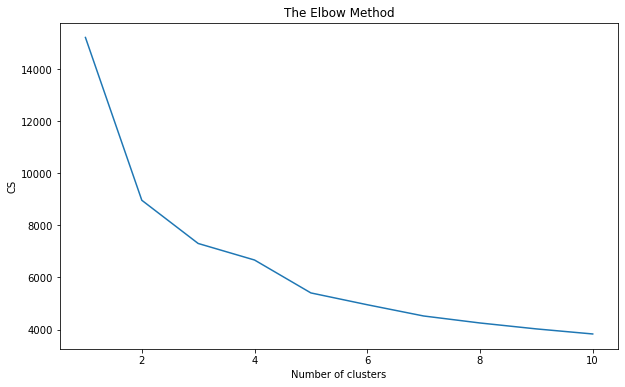

In [181]:
cs = []
for i in range(1, 11):
    kmeans_elb = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_elb.fit(X)
    cs.append(kmeans_elb.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

From the graph a value between 2-5 encapsulates the elbow. This is a good sign showing that our model is good to use for our data 

In [182]:
kl = KneeLocator(range(1, 11), cs, curve="convex", direction="decreasing")
kl.elbow

3

Not suprisingly the optimal value is 3, meaning that there are 3 main types of cars, which is correct. A bus, van and then 2 sedans

## PCA

The proper way to visualise the clustering our model chose is quite difficult. We put in 17 variables as inputs for our model which evaluated the distances the cluster point was from all the variables. The visulaisation above only gives us the clustering distrubution compared to 2 variables which are highly correlated. To include all 17 variables i would have to present a 17 dimensional graph, which couldnt be visualised. Principal component analysis helps reduce the 17 variables into 2 which can be easily visualised. after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [183]:
pca = PCA(n_components=2)

In [184]:
principalComponents = pca.fit_transform(clean)

In [185]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [186]:
principalDf

,principal component 1,principal component 2
0,0.334908,-0.274444
1,-1.562180,-0.393075
2,3.774102,0.206415
3,-1.696992,-2.818948
4,6.429570,4.144571
...,...,...
832,-0.427629,-0.622044
833,-0.310671,0.124920
834,4.812386,0.008931
835,-3.252780,-0.969916


In [187]:
clusters = pd.DataFrame({'Classification': kmeans.labels_})
clusters
finalDf = principalDf.join(clusters)

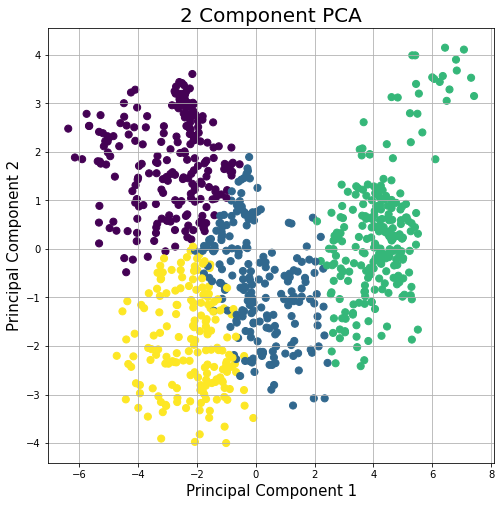

In [188]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Bus', 'Van', 'SAAB', 'Opel']
ax.scatter(finalDf['principal component 1']
               , finalDf['principal component 2']
               , c = finalDf['Classification']
               , s = 50)
ax.grid()

From the PCA we can visualise the clusters, now we can clearly see the different clusters

# TASK B

In [189]:
target = cleany.map(dict(bus= 2, van=3, opel = 1, saab = 0))
target

0      3
1      3
2      0
3      3
5      2
      ..
841    0
842    3
843    0
844    0
845    3
Name: Class, Length: 837, dtype: int64

In [190]:
dat = {"Predicted" : [219, 203, 176, 239], "Actual" : [217, 212, 215, 193], 'Cars': ["SAAB", "OPEL", "BUS", "VAN"]}
Comparision = pd.DataFrame(dat)
Comparision

,Predicted,Actual,Cars
0,219,217,SAAB
1,203,212,OPEL
2,176,215,BUS
3,239,193,VAN


This graph shows that our model favoured vans compared to buses and SAABS compared to Opels. Because SAAB and Opel would occupy similar clusters the cut off point would be difficult to gage and in this case looks like the cutoff was in SAABS favour. Same goes for the van as the model predicted that the data had alot more vans than buses 

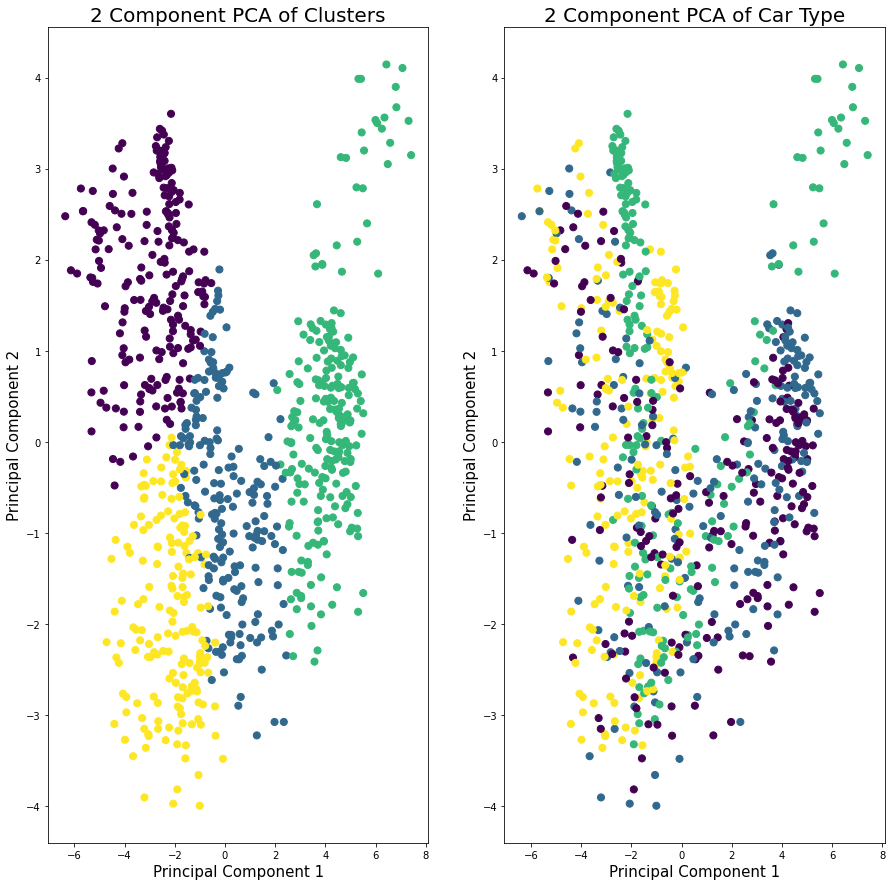

In [191]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.subplot(1,2,1) 
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA of Clusters', fontsize = 20)
plt.scatter(finalDf['principal component 1']
               , finalDf['principal component 2']
               , c = finalDf['Classification']
               , s = 50)

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA of Car Type', fontsize = 20)
plt.scatter(finalDf['principal component 1']
               , finalDf['principal component 2']
               , c = target
               , s = 50)

Text(0, 0.5, 'Variance Minor')

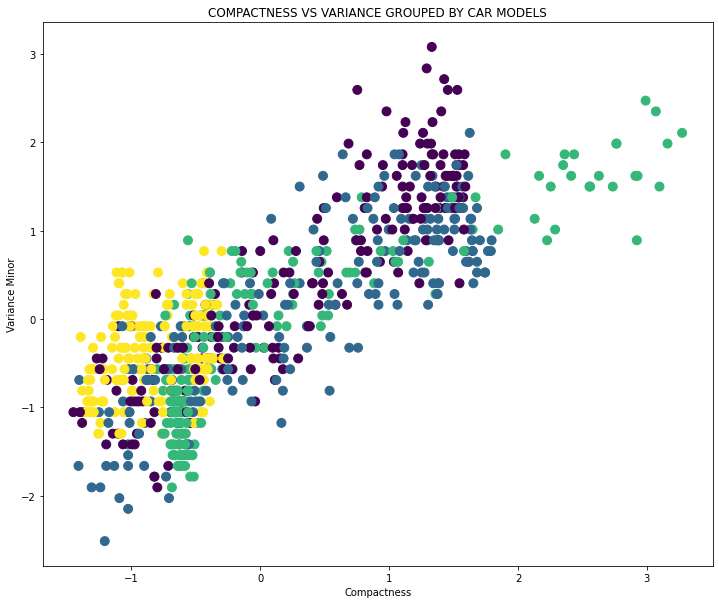

In [192]:
plt.figure(figsize = (12,10))
plt.scatter(y = clean['COMPACTNESS'], x =clean['SCALED_VARIANCE_MINOR'], c = target, s = 80)
plt.title("COMPACTNESS VS VARIANCE GROUPED BY CAR MODELS")
plt.xlabel("Compactness")
plt.ylabel("Variance Minor")

The graphs of the actual data looks very intermingled and visually can hardly make any clusters out of the groups.

## OPTIMIZATION

In [193]:
preprocessor = Pipeline(
                         [
                         ("scaler", MinMaxScaler()),
                         ("pca", PCA(n_components=2, random_state=42)),
])

init: You’ll use "k-means++" instead of "random" to ensure centroids are initialized with some distance between them. In most cases, this will be an improvement over "random".

n_init: You’ll increase the number of initializations to ensure you find a stable solution.

max_iter: You’ll increase the number of iterations per initialization to ensure that k-means will converge.

In [194]:
 clusterer = Pipeline([
             (
             "kmeans",
             KMeans(
             n_clusters = 4,
             init="k-means++",
             n_init=50,
             max_iter=500,
             random_state=42,
),),])

In [195]:
pipe = Pipeline(
       [
       ("preprocessor", preprocessor),
       ("clusterer", clusterer)
])

In [196]:
#unnormalized data chosen
pipe.fit(clean)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=4, n_init=50,
                                         random_state=42))]))])

In [197]:
preprocessed_data = pipe["preprocessor"].transform(clean)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
preds = pd.DataFrame(predicted_labels, columns = ['Predicted'])
silhouette_score(preds, target)

-0.11832255357958198

In [198]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(name)

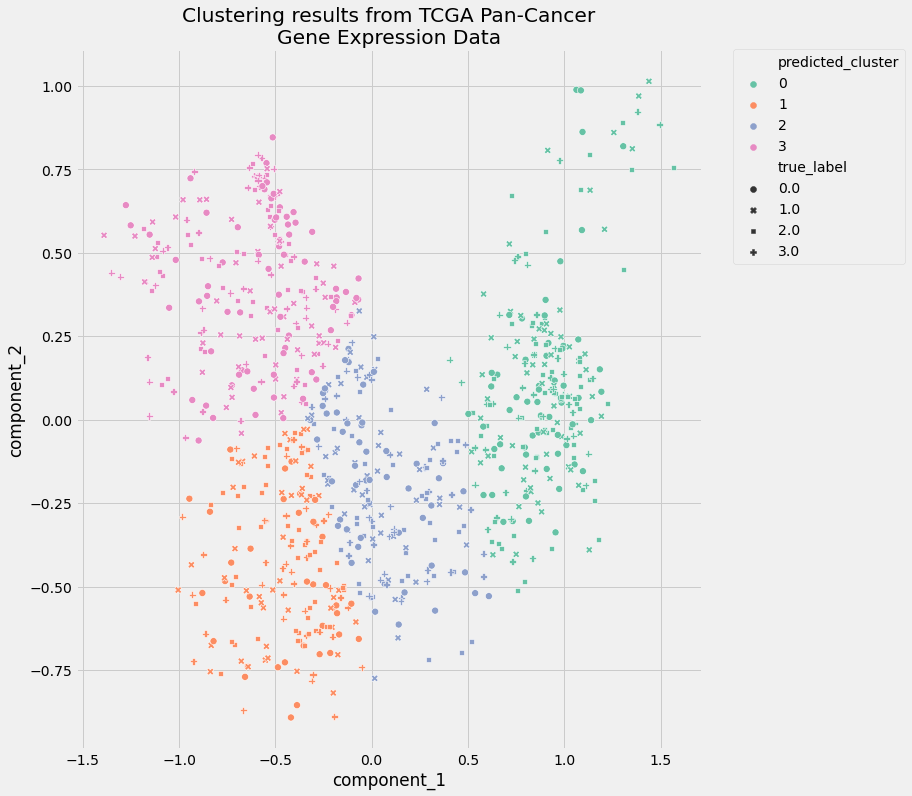

In [199]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(clean),
     columns=["component_1", "component_2"],
 )

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = target

plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 12))

scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     style="true_label",
     palette="Set2",
)

scat.set_title(
     "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [200]:
target

0      3
1      3
2      0
3      3
5      2
      ..
841    0
842    3
843    0
844    0
845    3
Name: Class, Length: 837, dtype: int64

# TASK C

In [201]:
#combining into one dataframe
dataset = clean.join(target)

In [202]:
dataset.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,0.160580,0.508950,0.057819,0.270806,1.307291,0.311542,-0.205844,0.136570,-0.224944,0.758332,-0.402383,-0.344935,0.285812,-0.329056,-0.076711,0.380991,-0.313722,0.183957,3
1,-0.325470,-0.626268,0.121261,-0.835244,-0.595396,0.094079,-0.597112,0.520843,-0.610954,-0.344578,-0.593611,-0.622416,-0.513517,-0.061767,0.533610,0.156925,0.010937,0.452977,3
2,1.254193,0.833298,1.517005,1.197496,0.546217,0.311542,1.148544,-1.144341,0.933086,0.689401,1.095564,1.104766,1.392577,0.071877,1.550812,-0.403238,-0.151393,0.049447,0
3,-0.082445,-0.626268,-0.005624,-0.297166,0.165679,0.094079,-0.747600,0.648935,-0.610954,-0.344578,-0.912323,-0.741337,-1.466565,-1.264566,-0.076711,-0.291206,1.634233,1.529056,3
5,1.618730,1.968516,1.517005,0.091446,-1.483316,-0.558308,2.593225,-1.912888,2.863136,1.447652,2.912223,2.928218,2.745289,1.675609,-0.280151,-0.403238,-1.287700,-1.699181,2


In [203]:
X_train, X_test, y_train, y_test = train_test_split(clean, target, test_size=0.3, random_state=42)

## REDUCING DIMENSIONS THROUGH PCA

In [204]:
# Calculating the covariance between attributes after scaling
cov_matrix = np.cov(clean.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00091375e+00  6.96768910e-01  7.94838680e-01  7.16891061e-01
   1.43191472e-01  2.16703987e-01  8.12871281e-01 -7.90086920e-01
   8.12766680e-01  6.81504567e-01  7.76818612e-01  8.17606971e-01
   5.88060482e-01 -2.26024889e-01  2.31101821e-01  1.58381655e-01
   2.98136252e-01  3.69612179e-01]
 [ 6.96768910e-01  1.00647758e+00  8.03821137e-01  6.24746282e-01
   1.45874080e-01  2.47160179e-01  8.64484923e-01 -8.34051626e-01
   8.61509870e-01  9.72668392e-01  8.07834776e-01  8.55967292e-01
   9.40277758e-01  4.92814458e-02  1.48680267e-01 -1.32215382e-02
  -1.11233615e-01  4.39466283e-02]
 [ 7.94838680e-01  8.03821137e-01  1.00642502e+00  7.84431205e-01
   1.81388090e-01  2.94551745e-01  9.11408108e-01 -9.17920794e-01
   8.98880454e-01  7.79993265e-01  8.72124644e-01  8.92927754e-01
   7.09797551e-01 -2.23863332e-01  1.15116388e-01  2.67723079e-01
   1.49201498e-01  3.40175002e-01]
 [ 7.16891061e-01  6.24746282e-01  7.84431205e-01  9.10929547e-01
   4.54718426e-

Covariance tells about information contained in the mathematical space between the independent attributes.

In [205]:
#Finding eigenvalues amd eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[ 2.77396167e-01  1.17783890e-01  7.36219036e-02  1.26609239e-01
  -6.60597950e-02  3.94766121e-01 -4.78727332e-02 -7.65814639e-01
   3.14541456e-01 -8.46399593e-02 -5.19644950e-02 -4.91481333e-03
   1.52072370e-01 -4.17852546e-05  1.90179132e-03  7.98650210e-02
   2.03376846e-02 -3.71616574e-03]
 [ 2.95563285e-01 -1.36951985e-01  1.87892453e-01 -7.38127183e-02
   2.64968801e-01 -1.81243594e-01 -2.39579875e-01 -2.73430146e-02
   7.21655408e-04  2.03697371e-01  1.32365575e-02  8.74164167e-02
   5.81019337e-02 -1.86182090e-02  1.87519162e-01 -2.34103753e-01
   6.07657610e-01 -4.23889752e-01]
 [ 3.06309851e-01  6.76000344e-02 -6.98984055e-02  5.74728436e-02
   1.37938283e-01 -2.27143870e-03  4.06252347e-01  2.13350015e-01
   3.20351447e-01  9.10702643e-02 -6.76490776e-01 -1.68779775e-01
  -2.19696860e-01  1.02365382e-02 -3.44878356e-02  2.99287056e-02
  -3.10593357e-02 -1.23926290e-01]
 [ 2.63345260e-01  2.07960069e-01 -4.05229150e-02 -1.58339130e-01
  -3.18542416e-01 -

Eigenvectors are the new dimensions of the new mathematical space.

Eigenvalues are the information content of each one of these eigenvectors or we can say it is the spread of these eigenvectors.

In [206]:
# Make a set of (eigenvalue, eigenvector) pairs
eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
eigen_pairs.sort(reverse=True)
eigen_pairs[:]

[(9.450811022073387,
  array([ 0.27739617,  0.29556328,  0.30630985,  0.26334526,  0.06787096,
          0.08286035,  0.31866966, -0.31571286,  0.31548219,  0.28264986,
          0.30572114,  0.31587694,  0.27119712, -0.03403141,  0.042046  ,
          0.05983474,  0.03272113,  0.07766362])),
 (3.0014572378616844,
  array([ 0.11778389, -0.13695199,  0.06760003,  0.20796007,  0.1748701 ,
          0.04586593, -0.05739595, -0.00525075, -0.0707455 , -0.12291536,
         -0.0545488 , -0.06205166, -0.21364597, -0.45438353,  0.05425432,
          0.11802053,  0.54347397,  0.54061487])),
 (1.1932929077863164,
  array([ 0.0736219 ,  0.18789245, -0.06989841, -0.04052291,  0.04045771,
          0.03111817, -0.09552052,  0.08280926, -0.09322159,  0.18916505,
         -0.11861712, -0.0929522 ,  0.2018235 , -0.06729297,  0.59862406,
         -0.67146154,  0.10173089,  0.04643503])),
 (0.9692624623669898,
  array([ 0.12660924, -0.07381272,  0.05747284, -0.15833913, -0.30445591,
          0.01010452

In [207]:
# print out eigenvalues
print('Eigenvalues in descending order: \n%s' %eigenvalues)

Eigenvalues in descending order: 
[9.45081102e+00 3.00145724e+00 1.19329291e+00 9.69262462e-01
 5.23344193e-01 4.73255910e-01 2.31312139e-01 2.08132875e-01
 1.00843033e-01 6.80925330e-02 5.58805280e-02 4.14402823e-02
 2.92680525e-02 3.54865309e-04 5.92399502e-03 1.77495275e-02
 1.19261627e-02 1.45603673e-02]


Cumulative Variance Explained [ 57.63776297  75.94278256  83.22033087  89.13158228  92.32330715
  95.20955807  96.6202639   97.88960611  98.5046186   98.91989526
  99.26069444  99.51342674  99.69192413  99.80017336  99.88897283
  99.96170705  99.99783578 100.        ]


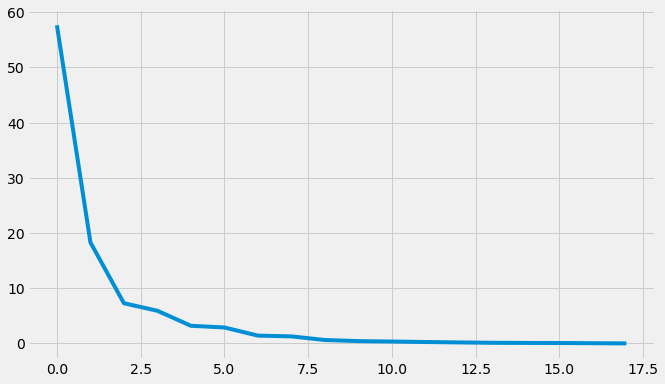

In [208]:
#finding variance and cummulative variance by each eigenvector
tot = sum(eigenvalues)
var_exp = [( i /tot ) * 100 for i in sorted(eigenvalues, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained", cum_var_exp)
plt.plot(var_exp)

We can observe that their is steep drop in variance explained with increase in number the number of Principal Components.

Also, top 10 principal components contribute 98.5% variance (information). So, we can proceed further with 10 components.

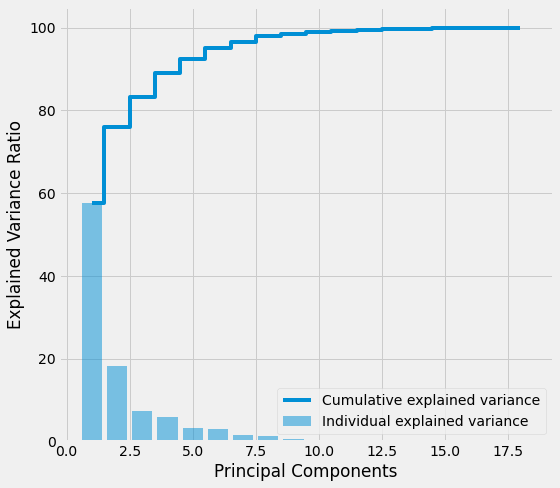

In [209]:
# Ploting 
plt.figure(figsize=(8 , 7))
plt.bar(range(1, eigenvalues.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eigenvalues.size + 1), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Here also we can visualize and eliminiate last 7 principal components because almost 98.5% of the data is captured by 10 principal components.

In [210]:
# Reducing from 17 to 10 dimension space
pca = PCA(n_components=10)
data_reduced = pca.fit_transform(clean)
data_reduced.transpose()

array([[ 0.3349082 , -1.56218038,  3.7741021 , ...,  4.81238577,
        -3.25278017, -4.72829381],
       [-0.27444405, -0.39307513,  0.20641483, ...,  0.00893064,
        -0.96991576,  0.37499939],
       [ 0.18647877,  0.22107354,  1.19623893, ...,  0.31032352,
        -1.93415487, -1.2261638 ],
       ...,
       [ 0.81433765, -0.13643561, -0.01236595, ...,  0.59719094,
        -0.35454719,  0.22139883],
       [-0.17622887,  0.02241776, -0.42128343, ...,  0.34634584,
        -0.99911349, -0.5984787 ],
       [-0.21861639,  0.23615828,  0.33051986, ..., -0.29553813,
         0.03412496, -0.39831299]])

In [211]:
pca.components_

array([[ 2.77396167e-01,  2.95563285e-01,  3.06309851e-01,
         2.63345260e-01,  6.78709622e-02,  8.28603539e-02,
         3.18669658e-01, -3.15712856e-01,  3.15482191e-01,
         2.82649860e-01,  3.05721135e-01,  3.15876942e-01,
         2.71197116e-01, -3.40314060e-02,  4.20459999e-02,
         5.98347393e-02,  3.27211295e-02,  7.76636216e-02],
       [-1.17783890e-01,  1.36951985e-01, -6.76000344e-02,
        -2.07960069e-01, -1.74870101e-01, -4.58659342e-02,
         5.73959488e-02,  5.25075451e-03,  7.07454993e-02,
         1.22915358e-01,  5.45488027e-02,  6.20516604e-02,
         2.13645967e-01,  4.54383532e-01, -5.42543221e-02,
        -1.18020530e-01, -5.43473969e-01, -5.40614868e-01],
       [ 7.36219036e-02,  1.87892453e-01, -6.98984055e-02,
        -4.05229150e-02,  4.04577072e-02,  3.11181660e-02,
        -9.55205177e-02,  8.28092586e-02, -9.32215926e-02,
         1.89165051e-01, -1.18617119e-01, -9.29521986e-02,
         2.01823504e-01, -6.72929656e-02,  5.98624059e

In [212]:
X_comp = pd.DataFrame(pca.components_,columns=list(clean))
X_comp.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
0,0.277396,0.295563,0.306310,0.263345,0.067871,0.082860,0.318670,-0.315713,0.315482,0.282650,0.305721,0.315877,0.271197,-0.034031,0.042046,0.059835,0.032721,0.077664
1,-0.117784,0.136952,-0.067600,-0.207960,-0.174870,-0.045866,0.057396,0.005251,0.070745,0.122915,0.054549,0.062052,0.213646,0.454384,-0.054254,-0.118021,-0.543474,-0.540615
2,0.073622,0.187892,-0.069898,-0.040523,0.040458,0.031118,-0.095521,0.082809,-0.093222,0.189165,-0.118617,-0.092952,0.201824,-0.067293,0.598624,-0.671462,0.101731,0.046435
3,0.126609,-0.073813,0.057473,-0.158339,-0.304456,0.010105,0.016942,0.058881,0.040064,-0.051277,-0.015020,0.021283,-0.057485,0.023314,0.716811,0.570325,-0.071203,-0.026041
4,0.066060,-0.264969,-0.137938,0.318542,0.385240,-0.356902,0.097082,-0.139751,0.071124,-0.452400,0.203688,0.125620,-0.103903,0.250240,0.259669,-0.114688,0.100000,-0.263053


In [213]:
# P_reduce represents reduced mathematical space.
# Reducing from 17 to 10 dimension space
P_reduce = np.array(eigenvectors[0:10])   
# projecting original data into principal component dimensions
X_std_10D = np.dot(clean,P_reduce.T)   
# converting array to dataframe for pairplot
Proj_data_df = pd.DataFrame(X_std_10D)  

These dimensions should have nearly no correlation with each other as they are the most linearly independent variables from each other

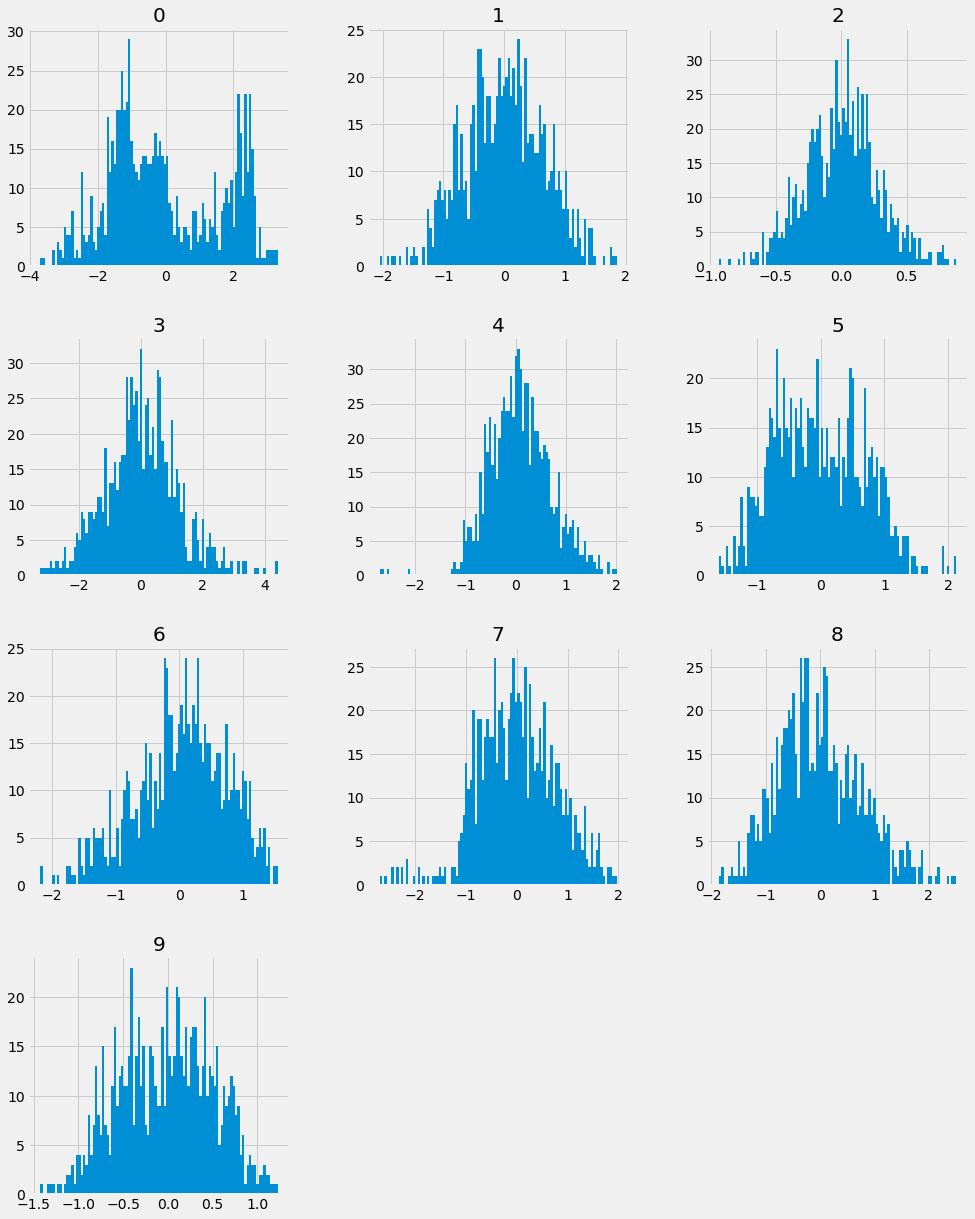

In [214]:
Proj_data_df.hist(bins = 100, figsize = (15, 20))
plt.show()

Will compare our models training with our projected data and cleaned data

In [215]:
pro_X_train, pro_X_test, pro_y_train, pro_y_test = train_test_split(Proj_data_df, target, test_size=0.3, random_state=42)

## 3 CLASSIFIERS

I will use Random Forests, SVM and Logisitic Regression

### RANDOM FORESTS

In [301]:
#finding best hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 35]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 35],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

n_iter controls the number of different combinations to try 

cv which is the number of folds to use for cross validation

In [302]:
#finding best parars
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

Now we can evaluate if all these hyperparameters are tuned correctly comparing our found ones vs sklearns default

In [307]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 41)
base_model.fit(X_train, y_train)
base_preds = base_model.predict(X_test)

In [308]:
#predictions come out continuous
base_preds

array([2, 0, 2, 2, 0, 0, 3, 2, 2, 3, 1, 0, 0, 1, 1, 1, 3, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 2, 0, 1, 3, 0, 1, 0, 3, 3, 0, 3, 3, 3, 3, 0, 2, 0,
       3, 3, 3, 1, 1, 2, 3, 3, 0, 0, 1, 2, 1, 2, 0, 3, 2, 2, 3, 3, 2, 3,
       1, 2, 1, 2, 1, 3, 2, 0, 1, 2, 3, 0, 0, 0, 0, 1, 3, 2, 0, 0, 3, 3,
       3, 2, 2, 2, 0, 0, 3, 1, 1, 1, 2, 0, 2, 1, 0, 3, 0, 2, 0, 2, 3, 0,
       2, 2, 2, 2, 1, 0, 0, 0, 2, 1, 1, 3, 3, 0, 0, 3, 1, 3, 0, 2, 3, 3,
       0, 3, 3, 0, 3, 3, 0, 2, 0, 3, 2, 3, 2, 3, 0, 0, 2, 1, 0, 3, 2, 1,
       2, 2, 1, 2, 0, 0, 0, 1, 3, 2, 3, 1, 0, 3, 2, 3, 2, 0, 3, 0, 2, 0,
       2, 1, 2, 0, 2, 0, 1, 3, 0, 1, 3, 3, 1, 0, 2, 3, 2, 0, 3, 0, 1, 3,
       3, 3, 2, 0, 3, 0, 0, 2, 1, 0, 3, 0, 2, 2, 0, 3, 3, 0, 1, 0, 1, 3,
       3, 0, 2, 2, 1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 1, 2, 0, 2, 0, 1, 0, 3,
       2, 2, 2, 0, 1, 0, 1, 0, 3, 2], dtype=int64)

In [309]:
#round all continuous to make classified
base_acc = accuracy_score(base_preds, y_test)
print("Test accuracy: {:.2f}%".format(base_acc*100))

Test accuracy: 62.30%


In [312]:
print("Training accuracy:", base_model.score(X_train,y_train))
acc_score = (base_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, base_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, base_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.9914529914529915
Testing accuracy:  0.623015873015873
Confusion Matrix: 
 [[30 25  7  0]
 [28 35  7  0]
 [ 0  4 54  0]
 [ 0  4 20 38]]
ROC AUC score:  0.8849292015436607


In [314]:
#best hyperparams
hype_model = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 1, max_features= 'sqrt', bootstrap = True, random_state = 41)
hype_model.fit(X_train, y_train)
hype_pred = hype_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Test accuracy: {:.2f}%".format(hype_acc*100))

Test accuracy: 73.41%


In [316]:
print("Training accuracy:", hype_model.score(X_train,y_train))
acc_score = (hype_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, hype_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, hype_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 1.0
Testing accuracy:  0.7341269841269841
Confusion Matrix: 
 [[37 15  4  6]
 [36 30  1  3]
 [ 0  0 57  1]
 [ 1  0  0 61]]
ROC AUC score:  0.9204547227012234


A slight improvement after hyperparamatization

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search We can use Grid Search that instead of sampling randomly from a distribution, evaluates all combinations we define.

In [288]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1000, 1800, 2300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1000, 1800, 2300]},
             verbose=2)

In [ ]:
grid_search.best_params_

In [294]:
#best hyperparams
hype_model = RandomForestRegressor(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 50, bootstrap = True, random_state = 41)
hype_model.fit(X_train, y_train)
hype_pred = hype_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Test accuracy: {:.2f}%".format(hype_acc*100))

Test accuracy: 67.06%


Looks like this is the highest test accuracy score acheivable with random forests

Now trying with our dimensionally reduced projected data set

In [318]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(pro_X_train, pro_y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 10],
                                        'min_samples_split': [2, 5, 10, 35],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

In [289]:
#best hyperparams
hype_model = RandomForestClassifier(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 1, max_features= 'sqrt', max_depth= 40, bootstrap = True, random_state = 41)
hype_model.fit(X_train, y_train)
hype_pred = hype_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Test accuracy: {:.2f}%".format(hype_acc*100))

Test accuracy: 67.06%


In [290]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [1000, 1800, 2300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [1000, 1800, 2300]},
             verbose=2)

In [ ]:
grid_search.best_params_

In [ ]:
#best hyperparams
hype_model = RandomForestRegressor(n_estimators = 1800, min_samples_split = 2, min_samples_leaf = 1, max_features= 'sqrt', max_depth= 30, bootstrap = True, random_state = 41)
hype_model.fit(X_train, y_train)
hype_pred = hype_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Test accuracy: {:.2f}%".format(hype_acc*100))

Looks like 67.06% is the ceiling for random forest on this data set

### SVC

In [ ]:
#calculating sklearns default value for gamma
defaultgamma = 1/(len(name)*clean.var())
defaultgamma

In [ ]:
#finding best hyperparameters
#different hyperplane used to separate the data
kernels = ['linear', 'rbf', 'sigmoid']
#gamma is for non linear hyperplanes
gammas = [0.1, 1, 10, 100]
#C is the penalty parameter of the error term
cs = [0.01, 0.05, 0.1, 1, 10]
#degree is a parameter used when kernel is set to ‘poly’
degrees = [0, 1, 2, 3]
#setting up grid
random_grid = {'kernel': kernels,
               'C': cs,
               'gamma': gammas,
               'degree': degrees,
               }

In [ ]:
# Use the random grid to search for best hyperparameters
# Fitting all params
grid = GridSearchCV(SVC(), random_grid, cv = 3, verbose=2, n_jobs = -1)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [321]:
base_model = SVC(probability = True).fit(X_train, y_train)
base_pred = base_model.predict(X_test)
base_preds = np.around(base_pred)
base_acc = accuracy_score(base_preds, y_test)
print("Test accuracy: {:.2f}%".format(base_acc*100))

Test accuracy: 75.00%


In [322]:
print("Training accuracy:", base_model.score(X_train,y_train))
acc_score = (base_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, base_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, base_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8444444444444444
Testing accuracy:  0.75
Confusion Matrix: 
 [[45 10  2  5]
 [40 27  1  2]
 [ 0  0 57  1]
 [ 0  0  2 60]]
ROC AUC score:  0.9322852085623459


In [251]:
#best hyperparams
hype_model = SVC(C = 0.05, degree = 1, gamma = 100, kernel = 'poly', random_state = 41, probability=True)
hype_model.fit(X_train, y_train)
hype_pred = hype_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Test accuracy: {:.2f}%".format(hype_acc*100))

Test accuracy: 80.56%


In [256]:
y_score = hype_model.predict_proba(X_test)
roc = roc_auc_score(y_test, y_score, multi_class = 'ovr')
roc

0.953156232909347

In [265]:
print("Training accuracy:", hype_model.score(X_train,y_train))
acc_score = (hype_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, hype_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, hype_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8512820512820513
Testing accuracy:  0.8055555555555556
Confusion Matrix: 
 [[39 19  2  2]
 [19 49  1  1]
 [ 1  1 56  0]
 [ 0  2  1 59]]
ROC AUC score:  0.953156232909347


Looks like SVC performed better than random forest.

Now to use the projected data

In [133]:
# Use the random grid to search for best hyperparameters
# Fitting all params
grid = GridSearchCV(SVC(), random_grid, cv = 3, verbose=2, n_jobs = -1)
grid.fit(pro_X_train, pro_y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 1, 10], 'degree': [0, 1, 2, 3],
                         'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=2)

In [109]:
grid.best_params_

{'C': 10, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'}

In [283]:
SVChype_model = SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability = True).fit(pro_X_train, pro_y_train)
SVChype_pred = SVChype_model.predict(pro_X_test)
SVChype_preds = np.around(SVChype_pred)
SVChype_acc = accuracy_score(SVChype_preds, pro_y_test)
print("Test accuracy: {:.2f}%".format(SVChype_acc*100))

Test accuracy: 72.22%


In [284]:
print("Training accuracy:", SVChype_model.score(pro_X_train, pro_y_train))
acc_score = (SVChype_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(pro_y_test, SVChype_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(pro_y_test, SVChype_model.predict_proba(pro_X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.905982905982906
Testing accuracy:  0.7222222222222222
Confusion Matrix: 
 [[42 15  1  4]
 [37 28  2  3]
 [ 1  1 55  1]
 [ 4  0  1 57]]
ROC AUC score:  0.917326971637545


### Logisitic Regression

In [267]:
#Specify the norm of the penalty
penaltys = ['l1', 'l2', 'elasticnet', 'none']
#Inverse of regularization strength
cs = [0.001, 0.005, 0.01, 0.1, 1]
#Algorithm to use in the optimization problem.
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']

random_grid = {'penalty' : penaltys,
               'C' : cs,
               'solver' : solvers
              }

In [268]:
grid = GridSearchCV(LogisticRegression(), random_grid, cv = 3, verbose=2)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1,

[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .............C=0.01

[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=newton-cg; total time=   0.1s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=1, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             verbose=2)

In [269]:
grid.best_params_

{'C': 0.001, 'penalty': 'none', 'solver': 'saga'}

In [324]:
base_model = LogisticRegression().fit(X_train, y_train)
base_pred = base_model.predict(X_test)
base_preds = np.around(base_pred)
base_acc = accuracy_score(base_preds, y_test)
print("Base Model test accuracy: {:.2f}%".format(base_acc*100))

Base Model test accuracy: 76.98%


In [325]:
print("Training accuracy:", base_model.score(X_train,y_train))
acc_score = (base_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, base_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, base_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8273504273504273
Testing accuracy:  0.7698412698412699
Confusion Matrix: 
 [[37 17  5  3]
 [23 41  4  2]
 [ 2  1 55  0]
 [ 0  0  1 61]]
ROC AUC score:  0.9430883660985897


In [329]:
hype_model = LogisticRegression(C = 0.01, penalty = 'none', solver = 'saga').fit(X_train, y_train)
hype_pred = base_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Base Model test accuracy: {:.2f}%".format(hype_acc*100))

Base Model test accuracy: 76.98%


In [91]:
grid = GridSearchCV(LogisticRegression(), random_grid, cv = 3, verbose=2)
grid.fit(pro_X_train, pro_y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1,

[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             verbose=2)

In [330]:
print("Training accuracy:", hype_model.score(X_train,y_train))
acc_score = (hype_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, hype_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, hype_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8461538461538461
Testing accuracy:  0.7698412698412699
Confusion Matrix: 
 [[37 17  5  3]
 [23 41  4  2]
 [ 2  1 55  0]
 [ 0  0  1 61]]
ROC AUC score:  0.9474147039156411


In [92]:
grid.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [272]:
hype_model = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg').fit(X_train, y_train)
hype_pred = base_model.predict(X_test)
hype_preds = np.around(hype_pred)
hype_acc = accuracy_score(hype_preds, y_test)
print("Base Model test accuracy: {:.2f}%".format(hype_acc*100))

Base Model test accuracy: 62.30%


In [273]:
print("Training accuracy:", hype_model.score(X_train,y_train))
acc_score = (hype_acc)
print('Testing accuracy: ', acc_score)
conf_mat = confusion_matrix(y_test, hype_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, hype_model.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8273504273504273
Testing accuracy:  0.623015873015873
Confusion Matrix: 
 [[30 25  7  0]
 [28 35  7  0]
 [ 0  4 54  0]
 [ 0  4 20 38]]
ROC AUC score:  0.9430883660985897


## Bagging

fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

In [95]:
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];

In [ ]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

In [96]:
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              
              
        }
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(clean,cleany) 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170,
                                          175, 180, 185]})

In [332]:
bag_pred = grid.predict(X_test)
bag_preds = np.around(bag_pred)
bag_acc = accuracy_score(bag_preds, y_test)
print("Base Model test accuracy: {:.2f}%".format(hype_acc*100))

Base Model test accuracy: 76.98%


In [336]:
print("Training accuracy:", grid.score(X_train,y_train))
bag_score = (bag_acc)
print('Testing accuracy: ', bag_score)
conf_mat = confusion_matrix(y_test, bag_preds)
print('Confusion Matrix: \n',conf_mat)
roc_auc = roc_auc_score(y_test, grid.predict_proba(X_test), multi_class = 'ovr')
print('ROC AUC score: ',roc_auc)

Training accuracy: 0.8427350427350427
Testing accuracy:  0.7698412698412699
Confusion Matrix: 
 [[40 18  3  1]
 [23 41  4  2]
 [ 2  1 54  1]
 [ 0  2  1 59]]
ROC AUC score:  0.9474163030925981
